Training a model using the nnUnet library 
see https://github.com/MIC-DKFZ/nnUNet/tree/master

1 - Convert a subset the competition dataset to nnunet format
2 - 

In [2]:
nnunet_dataset_name = "Dataset007_AMOS"

In [3]:
from src.config import config
import os
nnunet_train_dir = os.path.join(config["DATA_DIR"], "nnunet_raw", nnunet_dataset_name)
os.makedirs(nnunet_train_dir, exist_ok=True)
os.makedirs(os.path.join(nnunet_train_dir, "imagesTr"), exist_ok=True)
os.makedirs(os.path.join(nnunet_train_dir, "imagesTs"), exist_ok=True)
os.makedirs(os.path.join(nnunet_train_dir, "labelsTr"), exist_ok=True)
os.makedirs(os.path.join(nnunet_train_dir, "labelsTs"), exist_ok=True)


In [4]:
# use only a subdir

subset_name = "CT/CT_AMOS" # using a subset for now
train_dir = os.path.join(config["DATA_DIR"], "3D_train_npz_random_10percent_16G", subset_name)
files = [os.path.join(train_dir,f) for f in os.listdir(train_dir) if os.path.splitext(f)[1] == '.npz']
"""
# or full dataset
files = [os.path.join(dp, f) for dp, dn, filenames in os.walk(os.path.join(config["DATA_DIR"], "3D_train_npz_random_10percent_16G")) for f in filenames if os.path.splitext(f)[1] == '.npz']
"""

'\n# or full dataset\nfiles = [os.path.join(dp, f) for dp, dn, filenames in os.walk(os.path.join(config["DATA_DIR"], "3D_train_npz_random_10percent_16G")) for f in filenames if os.path.splitext(f)[1] == \'.npz\']\n'

In [5]:
len(files)
#files = files[:1]

30

In [6]:
import numpy as np
import nibabel as nib
import os
from multiprocessing import Pool
from functools import partial

def process_file(file_info, train_dir, nnunet_train_dir, total_files):
    i, file = file_info
    subset = "Tr" if i < total_files * 0.8 else "Ts"
    #print(f"file : {os.path.basename(file)}, {i}/{total_files}")
    
    data = np.load( file, allow_pickle=True)
    imgs = data["imgs"]
    spacing = data["spacing"]
    print(f"shape: {imgs.shape}")
    print(f"spacing: {spacing}")
    spacing = spacing[2], spacing[1], spacing[0]  # Adjusting to match NIfTI format (z, y, x)
    
    # Create affine matrix
    affine = np.eye(4)
    affine[0, 0] = data["spacing"][0]
    affine[1, 1] = data["spacing"][1]
    affine[2, 2] = data["spacing"][2]
    
    # Save images
    nib_img = nib.Nifti1Image(imgs, affine=affine)
    nib.save(nib_img, os.path.join(nnunet_train_dir, "images"+subset, os.path.basename(file).replace(".npz", "_0000.nii.gz")))
    
    # Process and save ground truth
    gts = data["gts"]
    print(np.unique(gts))
    #gts = (gts == 1).astype(np.int8)
    nib_gt = nib.Nifti1Image(gts, affine=affine)
    nib.save(nib_gt, os.path.join(nnunet_train_dir, "labels"+subset, os.path.basename(file).replace(".npz", ".nii.gz")))
    
    return file

# Main execution
# Create list of (index, filename) tuples
file_list = [(i, file) for i, file in enumerate(files)]

# Create partial function with fixed arguments
process_func = partial(process_file, 
                      train_dir=train_dir, 
                      nnunet_train_dir=nnunet_train_dir, 
                      total_files=len(files))

# Use 14 cores (leave 2 for system)
with Pool(processes=14) as pool:
    results = pool.map(process_func, file_list)

print(f"Processed {len(results)} files successfully")

shape: (59, 512, 512)
shape: (76, 512, 512)
shape: (66, 512, 512)
shape: (61, 512, 512)
spacing: [0.78200001 0.78200001 5.        ]spacing: [0.97265625 0.97265625 5.        ]spacing: [0.78200001 0.78200001 5.        ]
spacing: [0.78200001 0.78200001 5.        ]


shape: (73, 512, 512)
spacing: [0.90399998 0.90399998 5.        ]
shape: (58, 768, 768)
spacing: [0.65104169 0.65104169 5.        ]
shape: (105, 512, 512)
spacing: [0.83099997 0.83099997 5.        ]
shape: (108, 512, 512)
spacing: [0.75585902 0.75585902 2.5       ]
shape: (77, 512, 512)
spacing: [0.72265625 0.72265625 5.        ]
shape: (58, 768, 768)
spacing: [0.5703125 0.5703125 5.       ]
shape: (118, 512, 512)
spacing: [0.63085902 0.63085902 2.5       ]
shape: (88, 768, 768)
spacing: [0.5078125 0.5078125 5.       ]
shape: (111, 512, 512)
spacing: [0.67578125 0.67578125 5.        ]
shape: (147, 512, 512)
spacing: [0.5703125 0.5703125 2.       ]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[ 0  1  2  3  4  5  6  7  8  9

Image shape: (66, 512, 512)


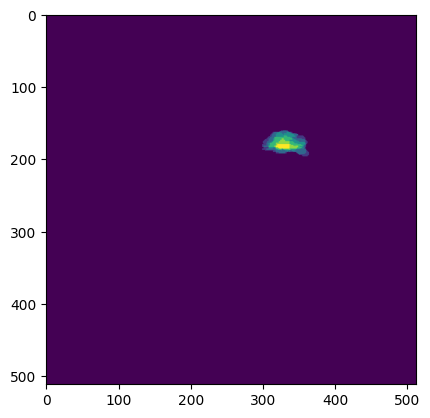

In [7]:
len(os.listdir(os.path.join(nnunet_train_dir,"labelsTr")))
# visualize one of the images
import matplotlib.pyplot as plt
import nibabel as nib
from numpy import spacing
img_path = os.path.join(nnunet_train_dir, "labelsTr", os.listdir(os.path.join(nnunet_train_dir, "labelsTr"))[0])
img = nib.load(img_path)
img_data = img.get_fdata()
spacing = img.header.get_zooms()
print(f"Image shape: {img_data.shape}")
gt1 = img_data == 1
plt.imshow(gt1.mean(axis=0),)

    

In [8]:
#export the variables for dataset location (see https://github.com/MIC-DKFZ/nnUNet/blob/master/documentation/set_environment_variables.md)
import os
os.environ["nnUNet_raw"] = os.path.join(config["DATA_DIR"], "nnunet_raw")
os.environ["nnUNet_preprocessed"] = os.path.join(config["DATA_DIR"], "nnUNet_preprocessed") 
os.environ["nnUNet_results"] = os.path.join(config["DATA_DIR"], "nnUNet_results")
os.environ["NNINT_CKPT_DIR"] = config["NNINT_CKPT_DIR"]

In [9]:
# easy paste when using a terminal
for var_name in ["nnUNet_raw", "nnUNet_preprocessed", "nnUNet_results","NNINT_CKPT_DIR"]:
    print("export " + var_name + "=" + os.environ[var_name])

export nnUNet_raw=/nfs/data/nii/data1/Analysis/GPUnet/ANALYSIS_incontext/SegFM3D/data/nnunet_raw
export nnUNet_preprocessed=/nfs/data/nii/data1/Analysis/GPUnet/ANALYSIS_incontext/SegFM3D/data/nnUNet_preprocessed
export nnUNet_results=/nfs/data/nii/data1/Analysis/GPUnet/ANALYSIS_incontext/SegFM3D/data/nnUNet_results
export NNINT_CKPT_DIR=/nfs/norasys/notebooks/camaret/model_checkpoints/nnint


In [ ]:
# Ressource request on nora

--time=2-0 --nodelist=loki --gpus-per-node=1  --cpus-per-task=16 --mem=64G

source /software/anaconda3/etc/profile.d/conda.sh
conda activate segfm3d_2
cd /nfs/norasys/notebooks/camaret/segfm3d_nora_team
/software/inetaccess/inetaccess camaret

export TORCH_COMPILE_DISABLE=1

SyntaxError: invalid decimal literal (2039321317.py, line 3)

using nninteractive plans :

In [ ]:
nnUNetv2_extract_fingerprint -d 7 --verify_dataset_integrity


# a) using ResEnc plans : 
nnUNetv2_plan_experiment -d 7 -pl nnUNetPlannerResEncL
nnUNetv2_preprocess -d 7 -c 3d_fullres


# b) using plans from nnInteractive_v1.0 :
# cp nnInteractive_v1.0/plans.json $nnUNet_preprocessed/DatasetXXX_XXX/nnUNetResEncUNetLPlans_noResampling.json
# in nnUNetResEncUNetLPlans_noResampling.json :
# change the "dataset_name" field to the current one
# change the "resampling..." fields to another method since we cannot access "no_resampling_hack" (e.g. "resample_data_or_seg_to_shape")
# add a method 3d_fullres_ps192_bs1 that sets batch size = 1 since we are gpu poor 

# preprocess the dataset
nnUNetv2_preprocess -d 6 -np 12 -plans_name nnUNetResEncUNetLPlans_noResampling -c 3d_fullres_ps192_bs1


# define a custom trainer in  nnUNet/nnunetv2/training/nnUNetTrainer/CustomTrainer.py
# train using the custom trainer with our preprocessing steps
nnUNetv2_train 6 3d_fullres_ps192 0 -p nnUNetResEncUNetLPlans_noResampling -tr CustomTrainer -num_gpus 1 -pretrained_weights $NNINT_CKPT_DIR/nnInteractive_v1.0/fold_0/checkpoint_final.pth
# additional args : 
-num_gpus 1 -pretrained_weights /nfs/data/nii/data1/Analysis/GPUnet/ANALYSIS_incontext/SegFM3D/checkpoints/nnInteractive_v1.0/fold_0/checkpoint_final.pth

In [ ]:
# cp nnInteractive_v1.0/inference_session_class.json to $nnUNet_results/DatasetXXX_XXX/CustomTrainer__nnUNetResEncUNetLPlans_noResampling__3d_fullres_ps192_bs1

# weights are ready to be picked by the nnInteractive.inference.inference_session class
import torch
from nnInteractive.inference.inference_session import nnInteractiveInferenceSession
session = nnInteractiveInferenceSession(
    device=torch.device("cpu"),  # Set inference device
    use_torch_compile=False,  # Experimental: Not tested yet
    verbose=False,
    torch_n_threads=1,  # Use available CPU cores
    do_autozoom=True,  # Enables AutoZoom for better patching
    use_pinned_memory=True,  # Optimizes GPU memory transfers
)




In [ ]:
# Load the trained model
model_training_output_dir = os.path.join(os.environ["nnUNet_results"], "Dataset002_CT_Abdomen1K/CustomTrainer__nnUNetResEncUNetLPlans_noResampling__3d_fullres_ps192_bs1")
model_training_output_dir = os.path.join(os.environ["nnUNet_results"], "Dataset006_AMOS/CustomTrainer__nnUNetResEncUNetLPlans_noResampling__3d_fullres_ps192")

session.initialize_from_trained_model_folder(model_training_output_dir)

Building network architecture with 8 input channels


In [ ]:
# evaluating the trained model on the segfm3d task : 
python scripts/eval.py -ca 0 -m nnint_custom --checkpoint_path /nfs/data/nii/data1/Analysis/GPUnet/ANALYSIS_incontext/SegFM3D/data/nnUNet_results/Dataset006_AMOS/CustomTrainer__nnUNetResEncUNetLPlans_noResampling__3d_fullres_ps192
python scripts/eval.py -ca 0 -m nnint_custom --checkpoint_path $NNINT_CKPT_DIR/nnInteractive_ours

python scripts/eval.py -ca 0 -m nnint_custom --checkpoint_path $nnUNet_results/Dataset006_AMOS/CustomTrainer__nnUNetResEncUNetLPlans_noResampling__3d_fullres_ps192


In [ ]:

# Also possible to avoid the nnInteractive class alltogether

from nnunetv2.utilities.label_handling.label_handling import determine_num_input_channels
from nnunetv2.utilities.find_class_by_name import recursive_find_python_class

from nnunetv2.utilities.plans_handling.plans_handler import PlansManager, ConfigurationManager
from batchgenerators.utilities.file_and_folder_operations import load_json, join, subdirs
from nnInteractive.trainer.nnInteractiveTrainer import nnInteractiveTrainer_stub

import nnInteractive
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset_json = load_json(join(model_training_output_dir, 'dataset.json'))
plans = load_json(os.path.join(model_training_output_dir, 'plans.json'))
plans_manager = PlansManager(plans)
checkpoint = torch.load(os.path.join(model_training_output_dir,"fold_0/checkpoint_final.pth"), map_location=device, weights_only=False)

configuration_name = checkpoint['init_args']['configuration']

parameters = checkpoint['network_weights']

configuration_manager = plans_manager.get_configuration(configuration_name)

trainer_name = checkpoint['trainer_name']

num_input_channels = determine_num_input_channels(plans_manager, configuration_manager, dataset_json)


trainer_class = recursive_find_python_class(join(nnInteractive.__path__[0], "trainer"),
                                            trainer_name, 'nnInteractive.trainer')
if trainer_class is None:
    print(f'Unable to locate trainer class {trainer_name} in nnInteractive.trainer. '
                        f'Please place it there (in any .py file)!')
    print('Attempting to use default nnInteractiveTrainer_stub. If you encounter errors, this is where you need to look!')
    trainer_class = nnInteractiveTrainer_stub

network = trainer_class.build_network_architecture(
    configuration_manager.network_arch_class_name,
    configuration_manager.network_arch_init_kwargs,
    configuration_manager.network_arch_init_kwargs_req_import,
    num_input_channels,
    plans_manager.get_label_manager(dataset_json).num_segmentation_heads,
    enable_deep_supervision=False
).to(device)
network.load_state_dict(parameters)





model_info = {
    "model_type": type(network).__name__,
    "model_module": type(network).__module__,
    "num_parameters": sum(p.numel() for p in network.parameters()),
    "input_channels": num_input_channels,
    "output_classes": plans_manager.get_label_manager(dataset_json).num_segmentation_heads,
    "configuration_name": configuration_name,
    "network_arch_class_name": configuration_manager.network_arch_class_name,
    "network_arch_init_kwargs": configuration_manager.network_arch_init_kwargs,
    "network_arch_init_kwargs_req_import": configuration_manager.network_arch_init_kwargs_req_import
}

print("Model Info:")
for key, value in model_info.items():
    print(f"{key}: {value}")
print("Model loaded successfully.")

Building network architecture with 8 input channels
Model Info:
model_type: ResidualEncoderUNet
model_module: dynamic_network_architectures.architectures.unet
num_parameters: 102355818
input_channels: 1
output_classes: 2
configuration_name: 3d_fullres_ps192_bs1
network_arch_class_name: dynamic_network_architectures.architectures.unet.ResidualEncoderUNet
network_arch_init_kwargs: {'n_stages': 6, 'features_per_stage': [32, 64, 128, 256, 320, 320], 'conv_op': 'torch.nn.modules.conv.Conv3d', 'kernel_sizes': [[3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3]], 'strides': [[1, 1, 1], [2, 2, 2], [2, 2, 2], [2, 2, 2], [2, 2, 2], [2, 2, 2]], 'n_blocks_per_stage': [1, 3, 4, 6, 6, 6], 'n_conv_per_stage_decoder': [1, 1, 1, 1, 1], 'conv_bias': True, 'norm_op': 'torch.nn.modules.instancenorm.InstanceNorm3d', 'norm_op_kwargs': {'eps': 1e-05, 'affine': True}, 'dropout_op': None, 'dropout_op_kwargs': None, 'nonlin': 'torch.nn.LeakyReLU', 'nonlin_kwargs': {'inplace': True}}
network_arch_i

In [ ]:
config

{'DATA_DIR': '/nfs/data/nii/data1/Analysis/GPUnet/ANALYSIS_incontext/SegFM3D/data',
 'RESULTS_DIR': '/nfs/data/nii/data1/Analysis/GPUnet/ANALYSIS_incontext/SegFM3D/results',
 'SAM_CKPT_PATH': '/nfs/norasys/notebooks/camaret/SAM-Med3D/ckpt/sam_med3d_turbo_bbox_cvpr.pth',
 'SAM_REPO_DIR': '/nfs/norasys/notebooks/camaret/SAM-Med3D',
 'ONNX_MODEL_PATH': '/nfs/norasys/notebooks/camaret/model_inference/models/sammed3d.onnx',
 'NNINT_CKPT_DIR': '/nfs/norasys/notebooks/camaret/model_checkpoints/nnint'}